# **Download data from Google Drive and check GPU/CPU**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%cd /content/drive/My Drive/Colab_Notebooks/Data


Since the data are divided into folders, let's download from, respectively.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from sklearn.manifold import TSNE

# Create a list with the filepaths for training and testing
train_dir = Path('/content/drive/MyDrive/fruits_and_vegetables_classification/Data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/drive/MyDrive/fruits_and_vegetables_classification/Data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('/content/drive/MyDrive/fruits_and_vegetables_classification/Data/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.935487060000014
GPU (s):
0.04291036899996925
GPU speedup over CPU: 68x


In [ ]:
def path_to_image(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = path_to_image(train_filepaths)
test_df = path_to_image(test_filepaths)
val_df = path_to_image(val_filepaths)

In [ ]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/fruits_and_vegetables_c...,spinach
1,/content/drive/MyDrive/fruits_and_vegetables_c...,corn
2,/content/drive/MyDrive/fruits_and_vegetables_c...,paprika
3,/content/drive/MyDrive/fruits_and_vegetables_c...,eggplant
4,/content/drive/MyDrive/fruits_and_vegetables_c...,carrot


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


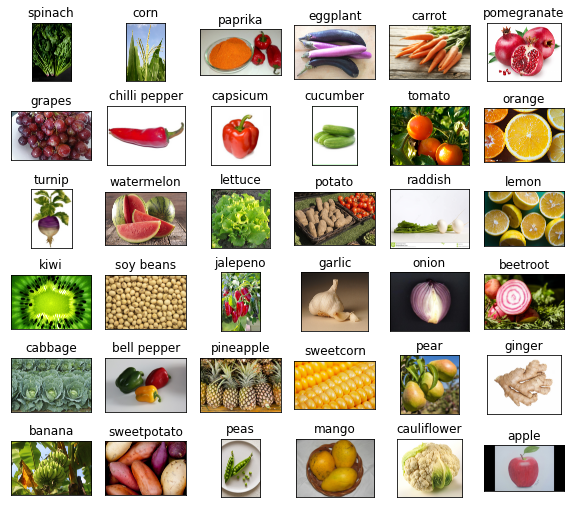

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# Make data augmentation 

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical', #loss
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    vertical_flip = True,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.resnet50.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False
inputs = pretrained_model.input

y = tf.keras.layers.Dropout(0.5)(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(y)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics= ["mae", "acc"]
)
"""
#Creating a model
#Make fitting
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True
        )
    ]
)
"""

# Saving and load trained model to/from google disk


In [ ]:
def save_model(flag = False):
   model.save('/content/drive/MyDrive/fruits_and_vegetables_classification/Data')

model = keras.models.load_model('/content/drive/MyDrive/fruits_and_vegetables_classification/Data')
#треба
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics= ["mae", "acc"]
)


In [ ]:
model.evaluate(test_images)

 6/11 [===============>..............] - ETA: 8s - loss: 0.2593 - mae: 0.0061 - acc: 0.9167 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


11/11 [==============================] - 20s 2s/step - loss: 0.2088 - mae: 0.0057 - acc: 0.9251


[0.20881249010562897, 0.005745199508965015, 0.92514967918396]

# Fine-tuning

In [ ]:
"""
last_layers = model.layers[-5:]
for layer in last_layers:
  layer.trainable = True

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True
        )
    ]
)
"""

"\nlast_layers = model.layers[-5:]\nfor layer in last_layers:\n  layer.trainable = True\n\nhistory = model.fit(\n    train_images,\n    validation_data=val_images,\n    batch_size = 32,\n    epochs=15,\n    callbacks=[\n        tf.keras.callbacks.EarlyStopping(\n            monitor='val_loss',\n            patience=4,\n            restore_best_weights=True\n        )\n    ]\n)\n"

In [ ]:
model.evaluate(test_images)

 6/11 [===============>..............] - ETA: 8s - loss: 0.2593 - mae: 0.0061 - acc: 0.9167

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


11/11 [==============================] - 18s 2s/step - loss: 0.2088 - mae: 0.0057 - acc: 0.9251


[0.20881249010562897, 0.005745199508965015, 0.92514967918396]

In [ ]:
def save_model(flag = False):
   model.save('/content/drive/MyDrive/fruits_and_vegetables_classification/Eve_Data')

model = keras.models.load_model('/content/drive/MyDrive/fruits_and_vegetables_classification/Data')
#треба
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics= ["mae", "acc"]
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Making predictions

In [ ]:
pred_0 = model.predict(test_images)
pred = np.argmax(pred_0,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 92.51%


# Visualising with **TSNE**

In [ ]:
load_model = False

if load_model:
  inputs = pretrained_model.input
  model = keras.models.load_model('/content/drive/MyDrive/fruits_and_vegetables_classification/Data')
  out = model.get_layer('dense').output
else:  
  out = model.layers[-2].output

In [ ]:
tsne = TSNE(n_components=2, perplexity=10, learning_rate=100, angle=0.2, verbose=2)
transform = tsne.fit_transform(pred_0)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 334 samples in 0.000s...
[t-SNE] Computed neighbors for 334 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 334 / 334
[t-SNE] Mean sigma: 0.284592
[t-SNE] Computed conditional probabilities in 0.013s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Iteration 50: error = 58.2061615, gradient norm = 0.6896567 (50 iterations in 0.165s)
[t-SNE] Iteration 100: error = 51.8205032, gradient norm = 0.6453537 (50 iterations in 0.111s)
[t-SNE] Iteration 150: error = 49.1956749, gradient norm = 0.6501634 (50 iterations in 0.100s)
[t-SNE] Iteration 200: error = 46.4660721, gradient norm = 0.6680464 (50 iterations in 0.099s)
[t-SNE] Iteration 250: error = 45.7239990, gradient norm = 0.6283857 (50 iterations in 0.108s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.723999
[t-SNE] Iteration 300: error = 0.2051576, gradient norm = 0.0010614 (50 iterations in 0.075s)
[t-SNE] Iteration 350: error = 0.1446504, gradient norm = 0.0003017 (50 iterations in 0.089s)
[t-SNE] Iteration 400: error = 0.1329679, gradient norm = 0.0001913 (50 iterations in 0.075s)
[t-SNE] Iteration 450: error = 0.1285854, gradient norm = 0.0001299 (50 iterations in 0.071s)
[t-SNE] Iteration 500: error = 0.1262783, gradient norm = 0.0001115 (50 

In [ ]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = transform[:, 0]
ty = transform[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


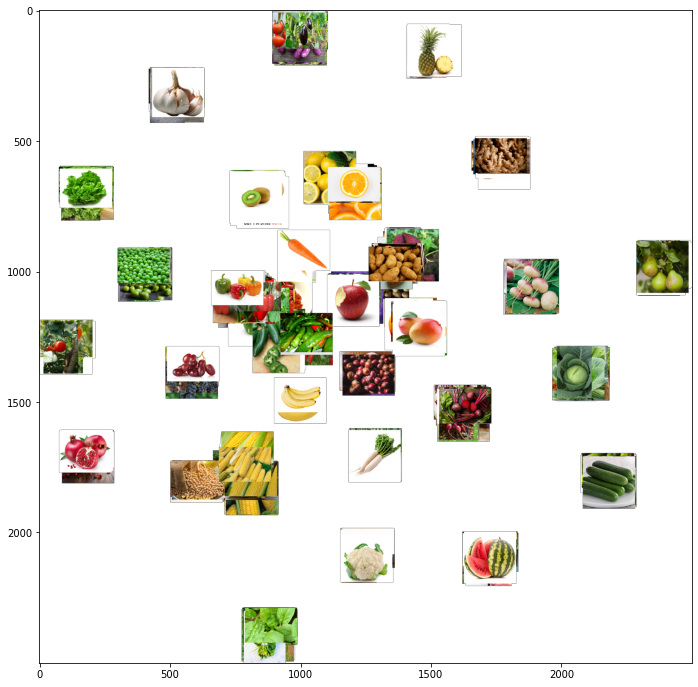

In [ ]:
width = 2500
height = 2500
max_dim = 200
save_to_png = True
te_filepath = test_df['Filepath'].tolist()

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(te_filepath, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
plt.figure(figsize = (16,12))
plt.imshow(full_image)

if save_to_png:
  full_image.save("/content/drive/MyDrive/fruits_and_vegetables_classification/2d_tsne_visualization.png")